## Power Law Examples

Below are a few examples of the original power law rating curve implementation.

In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

Equation for a orginal `ratingcurve` power law with $n$ breaks is:

\begin{equation}
  X = \ln({\rm max}(h - h_{s,\ n}, 0) + h_{0,\ n})
\end{equation}
\begin{equation}
  \ln(q) = a + b^T X + \epsilon + \epsilon_0
\end{equation}

where $h_{s,\ n}$ are the unknown segment breakpoints, $h_{0,\ n}$ is a vector of offsets, the first is 0 and the rest are 1; max is the element wise maximum, which returns a vector of size $h_{s,\ n}$; $a$ is a bias parameter (or scale factor); $b$ are the slopes of the log-transformed segments; $\epsilon$ is the residual error; and $\epsilon_0$ is the uncerainty in the discharge data. The offset vector $h_{0,\ n}$ ensures that $X \geq 0$, so additional segments never subtract discharge.

In [2]:
def PowerLaw(h: ArrayLike, a: ArrayLike, hs: ArrayLike, b: ArrayLike) -> np.ndarray:
    h = np.array(h)
    b_array = np.array(b)
    hs_array = np.array(hs).reshape((-1, 1))
    
    ho = np.ones((len(b_array), 1))
    ho[0] = 0

    X = np.log(np.clip(h - hs_array, 0, np.inf) + ho)

    logq = a + np.dot(b, X)

    q = np.exp(logq)
    
    return q

Now that we have created to equation function, let's generate some simulated data.

<function matplotlib.pyplot.show(close=None, block=None)>

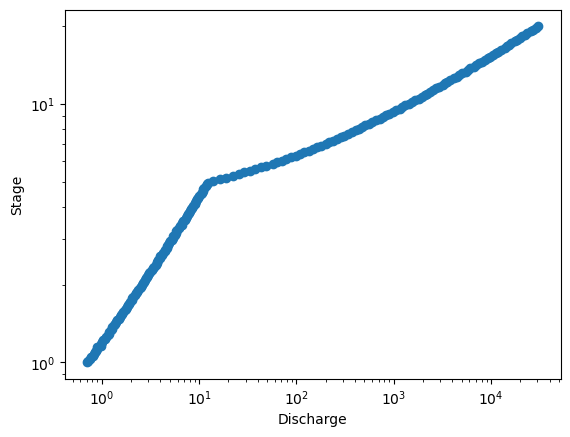

In [3]:
h = np.geomspace(1, 20, 201)
a = 0.01
hs = [0.2, 5.0]
b = [1.6, 2]
q = PowerLaw(h, a, hs, b)
# Add some random noise in log space
q = np.exp(np.log(q) + np.random.randn(len(q)) * 0.01)

fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.show

Then fit the simulated data and plot the fits.

In [4]:
from ratingcurve.modelbuilder_ratings import PowerLawRatingModel

# initialize the model
# Default model configurations are okay, as we want uniform priors and 2 segments
powerrating = PowerLawRatingModel()
powerrating.fit(h, q)
data = powerrating.table()

Convergence achieved at 38000
Interrupted at 37,999 [18%]: Average Loss = 3,767.9
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


Sampling: [model_q]


<function matplotlib.pyplot.show(close=None, block=None)>

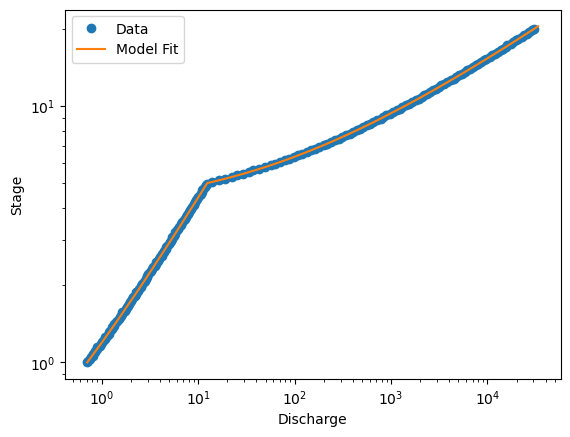

In [5]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

Sampling: [model_q]


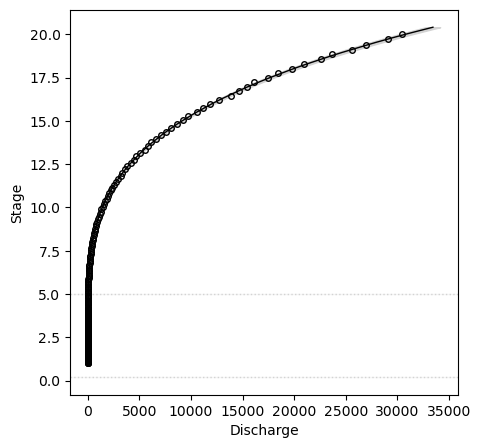

In [6]:
powerrating.plot()

Sampling: [model_q]


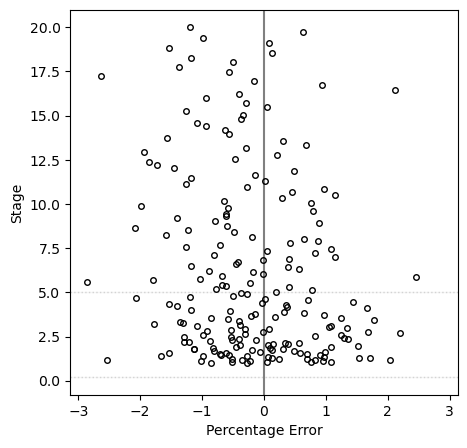

In [7]:
powerrating.plot_residuals()

In [8]:
print('Break point expected values: '+str(hs)+', Derived values: '
      +str(powerrating.idata.posterior.hs.mean(dim=['draw']).values.squeeze())+' +/- '
      +str(powerrating.idata.posterior.hs.std(dim=['draw']).values.squeeze()))

Break point expected values: [0.2, 5.0], Derived values: [0.19819409 4.99791542] +/- [0.00103458 0.00190536]


Let's see how this fit compares with the original power law rating.

The original power law model fit the data pretty well considering it was not used to generate the data like the smooth power law model. Now let's test both models on some real data to see how they compare on something less bias toward a certain model.

<function matplotlib.pyplot.show(close=None, block=None)>

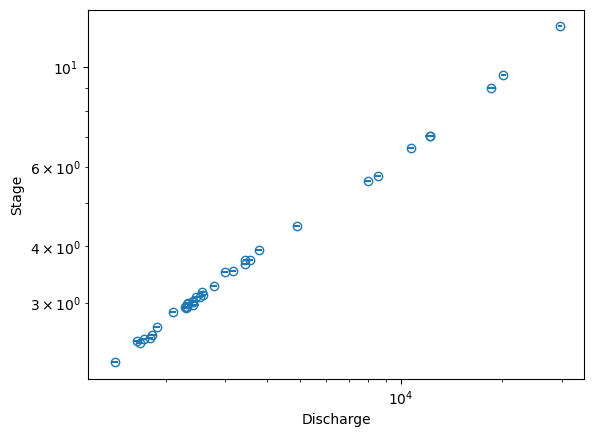

In [9]:
from ratingcurve import data

# load tutorial data
df = data.load('green channel')

fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.show

In [10]:
# initialize the model
# Default model config is still good here
powerrating_gc = PowerLawRatingModel(method='nuts')
powerrating_gc.fit(df['stage'], df['q'], df['q_sigma'])
data_gc = powerrating_gc.table()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, hs_]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 151 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


Sampling: [model_q]


<function matplotlib.pyplot.show(close=None, block=None)>

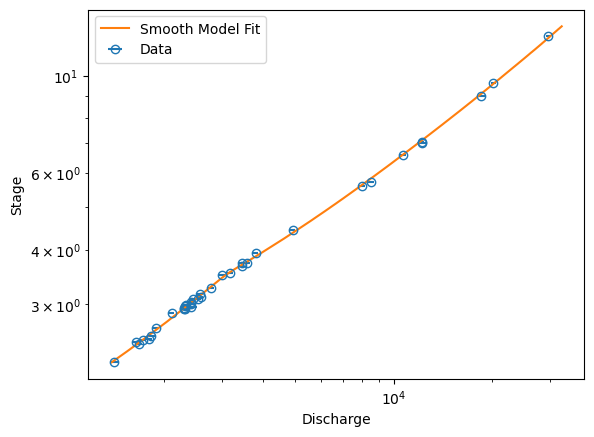

In [11]:
fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none', label='Data')
ax.loglog(data_gc['discharge'], data_gc['stage'], label='Smooth Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.legend()
plt.show

In [12]:
print('Break point derived values: '
      +str(powerrating_gc.idata.posterior.hs.mean(dim=['chain', 'draw']).values.squeeze())+' +/- '+str(powerrating_gc.idata.posterior.hs.std(dim=['chain', 'draw']).values.squeeze()))

Break point derived values: [0.72736588 4.32999277] +/- [0.31291496 2.09892234]


Sampling: [model_q]


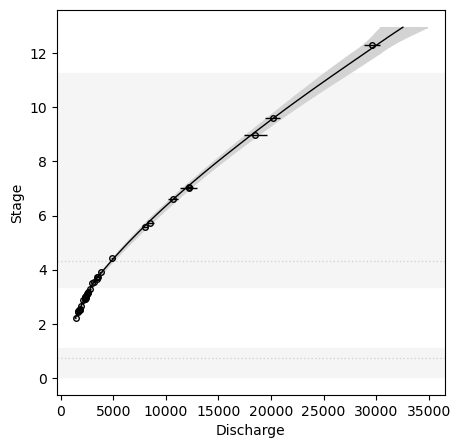

In [13]:
powerrating_gc.plot()